In [11]:
import os 
import sys 
sys.path.append('../lznestpy')

import nestpy
from random import choices
from nestUtils import *

import matplotlib.pyplot as plt
import numpy as np


In [26]:
detector = nestpy.LZ_Detector()
detector.SetSR1Configuration()

detector.set_s2_thr(0.)

field = 192 # V/cm
nc = nestpy.NESTcalc( detector )

sample_size = 1000000

In [22]:
EventRate_file = np.loadtxt("/Users/yxu/workbenches/XeArLoopworkbench/EventRatesMMA/Xe50zlTable.csv", skiprows=0,delimiter=',')

# Extract x and y values from the loaded data
x_values = EventRate_file[:,0]  # nElectrons column
y_values = EventRate_file[:,1]  # events/electron/kg/day column

# Perform numerical integration using trapezoidal rule
total_rate = np.trapz(y_values, x_values)/365.25/1E3

print(f"Total integrated rate: {total_rate:.6e} events/kg/day")
print(f"Total integrated rate: {365.25*1000*total_rate:.6e} events/tonne/year")


Total integrated rate: 5.798917e-06 events/kg/day
Total integrated rate: 2.118055e+00 events/tonne/year


In [23]:
n_samples = int(1E6)

# Normalize y_values to create probability weights
weights = y_values / np.sum(y_values)

sampled_energies = choices(x_values, weights=weights, k=n_samples)

eventWeight = total_rate/n_samples

print(f"Event weight: {eventWeight:.6e}")


Event weight: 5.798917e-12


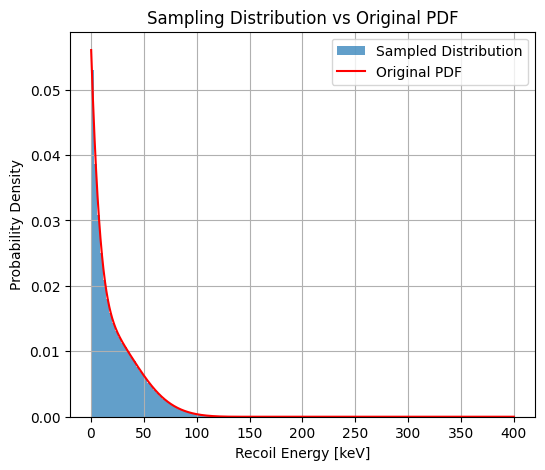

In [24]:
fig, axs = plt.subplots(figsize=(6, 5))

# Plot histogram of sampled energies
plt.hist(sampled_energies, bins=50, density=True, alpha=0.7, label='Sampled Distribution')
plt.plot(x_values, y_values/np.trapz(y_values, x_values), 'r-', label='Original PDF')
plt.xlabel('Recoil Energy [keV]')
plt.ylabel('Probability Density') 
plt.title('Sampling Distribution vs Original PDF')
plt.legend()
plt.grid(True)
plt.show()



In [27]:
interactionType = nestpy.INTERACTION_TYPE(0) # 0 for NR, 8 for betas      

quantas = generate_quanta(NESTcalc= nc, 
                          interaction= interactionType, 
                          energy_array= sampled_energies, 
                          field= field, 
                          density = 2.9)

Processing energy 0 of 1000000
Processing energy 10000 of 1000000
Processing energy 20000 of 1000000
Processing energy 30000 of 1000000
Processing energy 40000 of 1000000
Processing energy 50000 of 1000000
Processing energy 60000 of 1000000
Processing energy 70000 of 1000000
Processing energy 80000 of 1000000
Processing energy 90000 of 1000000
Processing energy 100000 of 1000000
Processing energy 110000 of 1000000
Processing energy 120000 of 1000000
Processing energy 130000 of 1000000
Processing energy 140000 of 1000000
Processing energy 150000 of 1000000
Processing energy 160000 of 1000000
Processing energy 170000 of 1000000
Processing energy 180000 of 1000000
Processing energy 190000 of 1000000
Processing energy 200000 of 1000000
Processing energy 210000 of 1000000
Processing energy 220000 of 1000000
Processing energy 230000 of 1000000
Processing energy 240000 of 1000000
Processing energy 250000 of 1000000
Processing energy 260000 of 1000000
Processing energy 270000 of 1000000
Proces

In [28]:
random_R2 = np.random.uniform( 0., 698.*698., sample_size )
random_phi = np.random.uniform( 0., 2.*np.pi, sample_size )
random_X = np.sqrt( random_R2 ) * np.cos( random_phi )
random_Y = np.sqrt( random_R2 ) * np.sin( random_phi )

random_driftTimes = np.random.uniform( 0., 1045., sample_size )

driftVelocity = nc.SetDriftVelocity(detector.get_T_Kelvin(), 2.9, field )
random_Z = detector.get_TopDrift() - random_driftTimes*driftVelocity


In [31]:
S1s = generate_S1_highEnergy(nc, 
                            interactionType, 
                            sampled_energies, 
                            field, 
                            quantas, 
                            random_X, 
                            random_Y, 
                            random_Z, 
                            driftVelocity)

S2s = (generate_S2(nc, 
                    interactionType, 
                    sampled_energies, 
                    field, 
                    quantas, 
                    random_X, 
                    random_Y, 
                    random_Z, 
                    driftVelocity, 
                    random_driftTimes ))


reconstructed_energies = 1E-3*13.7*(S1s/0.114 + S2s/47.1)


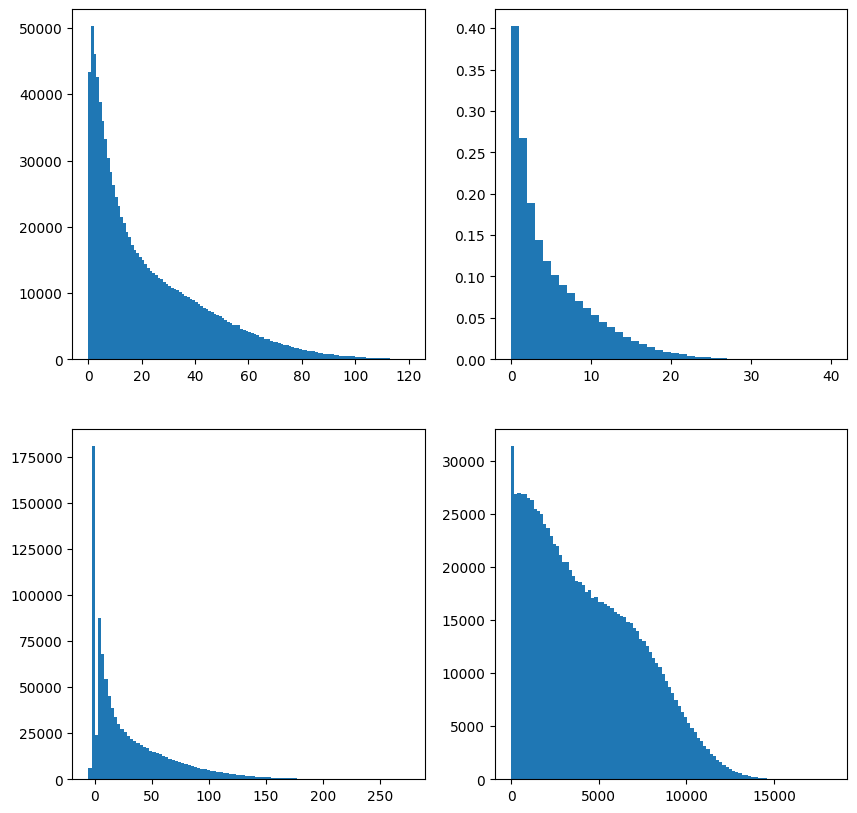

In [32]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].hist(sampled_energies, bins=np.linspace(0, 120, 121))
axs[0, 1].hist(reconstructed_energies, bins=np.linspace(0, 40, 41), weights=np.ones_like(reconstructed_energies)*eventWeight*365.25*1000*0.9)
axs[1, 0].hist(S1s, bins=100)
axs[1, 1].hist(S2s, bins=100)
plt.show()